# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

# Loading the Data

In [2]:
full_data_original = pd.read_pickle('full_all_data.pkl')

In [3]:
full_data_df = full_data_original.copy()

In [4]:
# initial look at the data
full_data_df.head()

,nb_id,repo_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,has_error,speaking_language,has_export,num_functions,has_test,num_headers,has_param,has_reqtext,num_stars,errors
0,0,165196403,False,False,False,False,0.995303,0.166667,0.538462,1.0,...,False,NaN,False,0.0,False,9.0,False,False,1.0,NaN
1,2,165196403,True,True,False,True,0.995303,0.965517,0.508475,1.0,...,False,NaN,False,0.0,False,10.0,False,False,1.0,NaN
2,3,165196403,False,False,False,False,0.995303,0.500000,0.529412,1.0,...,False,NaN,False,3.0,False,6.0,False,False,1.0,NaN
3,5,165196403,False,True,False,True,0.995303,0.461538,0.518519,1.0,...,False,NaN,False,7.0,False,10.0,False,False,1.0,NaN
4,7,165196403,NaN,NaN,False,True,0.995303,0.666667,0.571429,1.0,...,False,Norwegian,False,2.0,False,8.0,False,False,1.0,NaN


## Loading on Future Executions

In [5]:
# load in the pickle files
md_group_original = pd.read_pickle('full_markdown_group.pkl')
no_md_group_original = pd.read_pickle('full_no_markdown_group.pkl')

In [6]:
# make copies of the original dataframes
md_group = md_group_original.copy()
no_md_group = no_md_group_original.copy()

In [7]:
# check the data
md_group.head()

,nb_id,repo_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,exec_inorder,exec_skips,has_error,has_export,num_functions,has_test,num_headers,has_param,has_reqtext,num_stars
79,106,165198456,True,True,False,False,0.930911,0.363636,0.775510,1.0,...,0.75,4.500000,False,False,2.0,False,27.0,False,False,1.0
80,107,165198456,True,True,False,False,0.930911,0.000000,0.775510,1.0,...,1.00,0.000000,False,False,2.0,False,27.0,False,False,1.0
81,108,165197188,False,False,False,False,1.000000,0.560000,0.390244,1.0,...,1.00,1.913043,False,False,6.0,False,13.0,False,False,1.0
82,109,165197188,False,False,False,False,1.000000,0.560000,0.390244,1.0,...,1.00,1.913043,False,False,6.0,False,13.0,False,False,1.0
83,110,165197188,False,False,False,False,1.000000,0.588235,0.346154,1.0,...,1.00,0.000000,False,False,8.0,False,13.0,False,False,1.0


In [8]:
no_md_group.head()

,nb_id,repo_id,has_author,jupyter_prop,output_cell_prop,num_contrib,image_prop,is_education,has_comments,num_commits,non_exec_prop,exec_inorder,exec_skips,has_error,has_export,num_functions,has_test,has_param,has_reqtext,num_stars
85,113,165197465,False,1.000000,0.500000,1.0,0.000000,False,True,1.0,0.500000,1.000000,0.000000,False,False,1.0,False,False,False,0.0
90,118,165198993,False,1.000000,0.571429,1.0,0.416667,False,True,1.0,0.047619,0.944444,4.555556,False,False,1.0,False,False,False,0.0
91,119,165198993,False,1.000000,0.595745,1.0,0.571429,False,True,1.0,0.000000,0.956522,3.543478,True,True,1.0,False,False,False,0.0
94,122,165198375,False,0.578178,0.000000,1.0,0.000000,False,True,1.0,0.976190,1.000000,0.000000,False,True,21.0,False,False,False,0.0
109,137,165196460,False,0.967215,0.727273,1.0,0.250000,False,False,1.0,0.000000,1.000000,1.400000,False,False,0.0,False,False,False,0.0


In [30]:
# combine the two dataframes to make all data
full_data_df = pd.concat([md_group, no_md_group])
full_data_df.head()

,nb_id,repo_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,has_export,num_functions,has_test,num_headers,has_param,has_reqtext,num_stars,has_functions,has_headers,inorder_threshold
79,106,165198456,True,True,False,False,0.930911,0.363636,0.775510,1.0,...,False,2.0,False,27.0,False,False,1.0,True,True,False
80,107,165198456,True,True,False,False,0.930911,0.000000,0.775510,1.0,...,False,2.0,False,27.0,False,False,1.0,True,True,True
81,108,165197188,False,False,False,False,1.000000,0.560000,0.390244,1.0,...,False,6.0,False,13.0,False,False,1.0,True,True,True
82,109,165197188,False,False,False,False,1.000000,0.560000,0.390244,1.0,...,False,6.0,False,13.0,False,False,1.0,True,True,True
83,110,165197188,False,False,False,False,1.000000,0.588235,0.346154,1.0,...,False,8.0,False,13.0,False,False,1.0,True,True,True


In [31]:
len(full_data_df)

105701

# Filtering, Cleaning, and Grouping the Data

## Cleaning (errors)

In [6]:
# look at the errors
full_data_df['errors'].value_counts()

no code                                                    5528
filtered out                                                533
nb file                                                     300
has_author                                                  197
api                                                          97
has_reqtext                                                  81
num_commits                                                  32
output_cell_prop,image_prop                                   7
image_prop                                                    4
longer_beginning,longer_ending                                2
has_export,num_functions,has_test,num_headers,has_param       1
md_format                                                     1
has_export,num_functions                                      1
num_commits,has_reqtext                                       1
Name: errors, dtype: int64

We can filter those out with `no code`, `filtered out`, `nb file`, and `api` errors

In [8]:
condition = lambda error : error not in ['no code', 'filtered out', 'nb file', 'api']
error_filtered = full_data_df[full_data_df['errors'].map(condition)]

len(error_filtered)

136667

In [10]:
# look at errors again
error_filtered['errors'].value_counts()

has_author                                                 197
has_reqtext                                                 81
num_commits                                                 32
output_cell_prop,image_prop                                  7
image_prop                                                   4
longer_beginning,longer_ending                               2
has_export,num_functions,has_test,num_headers,has_param      1
md_format                                                    1
has_export,num_functions                                     1
num_commits,has_reqtext                                      1
Name: errors, dtype: int64

We can leave those with `has_author` errors, since the author URLs alone must have been invalid. We can assign those to a value of `False` for `has_author`

In [16]:
for nb_id in error_filtered[error_filtered['errors'] == 'has_author']['nb_id']:
    error_filtered.loc[error_filtered['nb_id'] == nb_id, 'has_author'] = False

In [20]:
# check that we assigned values correctly (no more nans in has_author)
error_filtered['has_author'].isna().sum()

0

We can now get rid of the `has_author` errors

In [22]:
for nb_id in error_filtered[error_filtered['errors'] == 'has_author']['nb_id']:
    error_filtered.loc[error_filtered['nb_id'] == nb_id, 'errors'] = np.nan

In [24]:
# check the errors again
error_filtered['errors'].value_counts()

has_reqtext                                                81
num_commits                                                32
output_cell_prop,image_prop                                 7
image_prop                                                  4
longer_beginning,longer_ending                              2
has_export,num_functions,has_test,num_headers,has_param     1
md_format                                                   1
has_export,num_functions                                    1
num_commits,has_reqtext                                     1
Name: errors, dtype: int64

Let's tackle the `has_reqtext` errors next

In [29]:
error_filtered[error_filtered['errors'] == 'has_reqtext'][['nb_id', 'has_reqtext']].head()

,nb_id,has_reqtext
2095,2223,NaN
11650,12256,NaN
15039,15821,NaN
17464,18541,NaN
22263,23601,NaN


Looking into these errors, it seems that the path was assigned incorrectly in the `notebooks.csv`, so we re-do the process of finding notebook path and running `has_requirements` for these notebooks.

Next, the `num_commits` errors

In [31]:
error_filtered[error_filtered['errors'] == 'num_commits'][['nb_id', 'num_commits']].head()

,nb_id,num_commits
5005,5260,NaN
5225,5495,NaN
11420,12011,NaN
11454,12047,NaN
41942,44300,NaN


Looking into these errors, it seems that the `%` characters in the notebook are not being escaped when the notebook paths are put into the URL, so we can re-do running the script on these notebooks and make sure to escape this character properly

The rest of the errors have less than 10 notebooks associated with them, so we can handle those individually

## Filtering

In [32]:
filtered = error_filtered.copy()

For now, let's filter out those that still have errors, as those will get resolved later

In [40]:
filtered = filtered[filtered['errors'].isnull()]
filtered['errors'].value_counts()

Series([], Name: errors, dtype: int64)

In [41]:
# we can now drop the errors column
filtered = filtered.drop(['errors'], axis = 1)

Next, we must filter down to just English and `python` notebooks

In [44]:
# look at the languages
filtered['language'].value_counts()

python                                                    126025
python3                                                     6774
julia                                                        985
R                                                            922
python2                                                      181
                                                           ...  
markdown                                                       1
python37564bitsidconda1d45427122d043f58fabe1fddaa2b008         1
python37764bitaa037e6b9ce0482a97f7f2f266a78e54                 1
lisp                                                           1
mathematica                                                    1
Name: language, Length: 71, dtype: int64

In [47]:
# drop the notebooks with 'nan' in the language column
filtered = filtered.dropna(subset = ['language'])

# filter down to those with python
filtered = filtered[filtered['language'].str.contains("python")]
len(filtered)

133071

In [48]:
# check new value counts
filtered['language'].value_counts()

python                                                              126025
python3                                                               6774
python2                                                                181
micropython                                                             65
python37164bitbasecondad2822a14379545b6ad8221fdb28a47f5                  5
python37664bite5e01d20666b4ea39b669a865bfedc91                           3
python37664bit63fb4f53efb44350a8fe54ef578d532a                           2
python37464bit2210ce78c9014828b7442ce7d2fdf2c3                           2
python37132bitsimplificandocondad4a025f5665f45f198698144d61138fc         2
python36964bit159e511b6454490fab42e7c387ca06d9                           2
python37464bitbaseconda688895a7bc4d4baeb81185c00bfb955a                  1
python3.5                                                                1
python2.7                                                                1
python36064bittfbaseconda

In [49]:
# we can now drop the language column
filtered = filtered.drop(['language'], axis = 1)

In [50]:
# look at the speaking languages
filtered['speaking_language'].value_counts()

English                    79938
Korean                      2257
Spanish                     1479
Russian                     1404
Portuguese                  1362
French                      1012
Welsh                        867
Japanese                     825
Catalan                      770
Norwegian                    765
Italian                      649
German                       550
Vietnamese                   521
Polish                       456
Romanian                     299
Estonian                     254
Indonesian                   231
Tagalog                      179
Danish                       148
Turkish                      145
Dutch                        119
Croatian                     117
Afrikaans                    106
Swedish                       65
Somali                        54
Bulgarian                     50
Czech                         45
Hungarian                     44
Finnish                       38
Modern Greek (1453-)          34
Thai      

In [53]:
# filter down to only english notebooks and notebooks with no markdown cells
filtered = filtered[(filtered['speaking_language'] == 'English') |
                   (filtered['markdown_prop'] == 0)]
len(filtered)

115821

In [52]:
# check the speaking languages again
filtered['speaking_language'].value_counts()

English    79938
Name: speaking_language, dtype: int64

In [54]:
# we now no longer need the speaking language column
filtered = filtered.drop(['speaking_language'], axis = 1)

## Cleaning and Adjusting (nan values)

In [56]:
adjusted = filtered.copy()

In [57]:
# check each column for NaN
for column in list(adjusted):
    hasNaN = adjusted[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
repo_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : True
jupyter_prop : True
output_cell_prop : False
markdown_prop : False
num_contrib : False
image_prop : True
is_education : False
has_links : True
has_comments : False
md_frequency : True
has_title : False
num_commits : False
md_format : True
non_exec_prop : False
exec_inorder : True
exec_skips : True
has_error : False
has_export : False
num_functions : False
has_test : False
num_headers : False
has_param : False
has_reqtext : False
num_stars : False


For the features associated with markdown cells, it is fine to have `NaN` values; we will separate the data into groups accordingly in a later section.
- `longer_beginning`
- `longer_ending`
- `has_equation`
- `has_links`
- `md_frequency`
- `md_format`

Let us look at the `jupyter_prop` nan values

In [61]:
len(adjusted[pd.isnull(adjusted['jupyter_prop'])])

23

In [62]:
adjusted[pd.isnull(adjusted['jupyter_prop'])].head()

,nb_id,repo_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,exec_inorder,exec_skips,has_error,has_export,num_functions,has_test,num_headers,has_param,has_reqtext,num_stars
48689,51490,168097544,False,False,False,False,NaN,0.000000,0.166667,1.0,...,NaN,NaN,False,True,0.0,False,4.0,False,False,0.0
57507,60734,168518417,False,False,False,False,NaN,0.636364,0.352941,7.0,...,1.000000,1.380952,False,False,0.0,False,6.0,False,False,18.0
57508,60735,168518417,False,False,False,False,NaN,0.600000,0.347826,7.0,...,1.000000,1.000000,False,False,0.0,False,5.0,False,False,18.0
57510,60737,168518417,False,False,False,False,NaN,0.888889,0.250000,7.0,...,0.857143,12.714286,False,False,0.0,False,0.0,False,False,18.0
57511,60738,168518417,False,False,False,False,NaN,0.529412,0.413793,7.0,...,1.000000,1.333333,False,False,0.0,False,6.0,False,False,18.0


These are notebooks of repositories for which `Jupyter Notebook` was left out in the language data, so we can filter these out

In [64]:
jupyter_nans = adjusted[pd.isnull(adjusted['jupyter_prop'])].index
adjusted = adjusted.drop(jupyter_nans, inplace = False)
len(adjusted)

115798

In [66]:
# check nans again
for column in list(adjusted):
    hasNaN = adjusted[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
repo_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : True
jupyter_prop : False
output_cell_prop : False
markdown_prop : False
num_contrib : False
image_prop : True
is_education : False
has_links : True
has_comments : False
md_frequency : True
has_title : False
num_commits : False
md_format : True
non_exec_prop : False
exec_inorder : True
exec_skips : True
has_error : False
has_export : False
num_functions : False
has_test : False
num_headers : False
has_param : False
has_reqtext : False
num_stars : False


Similar to how we did so on the last dataset, we can adjust values of the `image_prop`, `exec_inorder`, and `exec_skips` columns

In [67]:
# change NaN in image_prop to 0
adjusted['image_prop'] = adjusted['image_prop'].fillna(0)

In [68]:
# change NaN in exec_inorder to 1
adjusted['exec_inorder'] = adjusted['exec_inorder'].fillna(1)

# change NaN in exec_skips to 0
adjusted['exec_skips'] = adjusted['exec_skips'].fillna(0)

In [69]:
# check nans again
for column in list(adjusted):
    hasNaN = adjusted[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
repo_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : True
jupyter_prop : False
output_cell_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : True
has_comments : False
md_frequency : True
has_title : False
num_commits : False
md_format : True
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False
has_export : False
num_functions : False
has_test : False
num_headers : False
has_param : False
has_reqtext : False
num_stars : False


## Grouping

In [70]:
# separate into markdown cell group and non-markdown cell group
md_group = adjusted[adjusted['markdown_prop'] > 0].copy()
no_md_group = adjusted[adjusted['markdown_prop'] == 0].copy()

In [71]:
len(md_group) + len(no_md_group)

115798

In [78]:
# drop unnecessary columns from the no markdown cell group
no_md_group = no_md_group.drop(['longer_beginning', 'longer_ending', 'has_equation', 'markdown_prop', 'has_links',
                                        'md_frequency', 'md_format', 'has_title', 'num_headers'], axis = 1)

In [79]:
# check both groups for nans
for column in list(md_group):
    hasNaN = md_group[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
repo_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : False
jupyter_prop : False
output_cell_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : False
has_comments : False
md_frequency : False
has_title : False
num_commits : False
md_format : False
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False
has_export : False
num_functions : False
has_test : False
num_headers : False
has_param : False
has_reqtext : False
num_stars : False


In [80]:
# check out longer_beginning and longer_ending nans
print(len(md_group[pd.isnull(md_group['longer_beginning'])]))
print(len(md_group[pd.isnull(md_group['longer_ending'])]))

10097
10097


In [81]:
md_group = md_group.dropna(subset = ['longer_beginning', 'longer_ending'])

In [83]:
len(md_group) + len(no_md_group)

105701

In [89]:
# check both groups for nans
for column in list(md_group):
    hasNaN = md_group[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
repo_id : False
longer_beginning : False
longer_ending : False
has_author : False
has_equation : False
jupyter_prop : False
output_cell_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : False
has_comments : False
md_frequency : False
has_title : False
num_commits : False
md_format : False
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False
has_export : False
num_functions : False
has_test : False
num_headers : False
has_param : False
has_reqtext : False
num_stars : False


In [90]:
for column in list(no_md_group):
    hasNaN = no_md_group[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
repo_id : False
has_author : False
jupyter_prop : False
output_cell_prop : False
num_contrib : False
image_prop : False
is_education : False
has_comments : False
num_commits : False
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False
has_export : False
num_functions : False
has_test : False
has_param : False
has_reqtext : False
num_stars : False


We can export these cleaned and adjusted groups for quick retrieval later on.

In [84]:
md_group.to_pickle('full_markdown_group.pkl')
no_md_group.to_pickle('full_no_markdown_group.pkl')

# Analysis

## Loading Github 2017 Data

In [75]:
md_group_2017 = pd.read_csv('../output/complete-runs/analysis/markdown_group.csv')
no_md_group_2017 = pd.read_csv('../output/complete-runs/analysis/no_markdown_group.csv')

In [76]:
md_group_2017.head()

,Unnamed: 0,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,non_exec_prop,exec_inorder,exec_skips,has_error,has_export,num_functions,has_test,num_headers,has_param,num_stars
0,3,594,True,False,False,False,0.507588,1.000000,0.044444,3.0,...,0.000000,1.000000,1.809524,False,False,0.0,False,7.0,False,10.0
1,6,1222,True,False,False,False,1.000000,0.000000,0.161290,1.0,...,0.961538,1.000000,0.000000,False,False,0.0,False,5.0,False,0.0
2,7,1447,True,False,False,False,0.970851,0.011364,0.375887,1.0,...,0.988636,1.000000,0.000000,False,True,15.0,False,30.0,False,0.0
3,12,2705,True,False,False,False,1.000000,0.500000,0.461538,1.0,...,0.000000,0.923077,1.615385,False,False,6.0,False,7.0,False,0.0
4,15,2861,True,False,False,True,1.000000,0.214286,0.461538,1.0,...,0.000000,1.000000,6.333333,False,False,0.0,False,1.0,False,0.0


In [77]:
# drop first column from both
md_group_2017 = md_group_2017.drop(['Unnamed: 0'], axis = 1)
no_md_group_2017 = no_md_group_2017.drop(['Unnamed: 0'], axis = 1)

In [85]:
# check the columns for both datasets to be sure they match up
md_group_2017.columns

Index(['nb_id', 'longer_beginning', 'longer_ending', 'has_author',
       'has_equation', 'jupyter_prop', 'output_cell_prop', 'markdown_prop',
       'num_contrib', 'image_prop', 'is_education', 'has_links',
       'has_comments', 'md_frequency', 'has_title', 'num_commits', 'md_format',
       'non_exec_prop', 'exec_inorder', 'exec_skips', 'has_error',
       'has_export', 'num_functions', 'has_test', 'num_headers', 'has_param',
       'num_stars'],
      dtype='object')

In [86]:
md_group.columns

Index(['nb_id', 'repo_id', 'longer_beginning', 'longer_ending', 'has_author',
       'has_equation', 'jupyter_prop', 'output_cell_prop', 'markdown_prop',
       'num_contrib', 'image_prop', 'is_education', 'has_links',
       'has_comments', 'md_frequency', 'has_title', 'num_commits', 'md_format',
       'non_exec_prop', 'exec_inorder', 'exec_skips', 'has_error',
       'has_export', 'num_functions', 'has_test', 'num_headers', 'has_param',
       'has_reqtext', 'num_stars'],
      dtype='object')

In [87]:
no_md_group_2017.columns

Index(['nb_id', 'has_author', 'jupyter_prop', 'output_cell_prop',
       'num_contrib', 'image_prop', 'is_education', 'has_comments',
       'num_commits', 'non_exec_prop', 'exec_inorder', 'exec_skips',
       'has_error', 'has_export', 'num_functions', 'has_test', 'has_param',
       'num_stars'],
      dtype='object')

In [88]:
no_md_group.columns

Index(['nb_id', 'repo_id', 'has_author', 'jupyter_prop', 'output_cell_prop',
       'num_contrib', 'image_prop', 'is_education', 'has_comments',
       'num_commits', 'non_exec_prop', 'exec_inorder', 'exec_skips',
       'has_error', 'has_export', 'num_functions', 'has_test', 'has_param',
       'has_reqtext', 'num_stars'],
      dtype='object')

## Graphing and Comparison (between datasets)

These are the features that correlate with best practices:

- `md_frequency`
- `longer_beginning` and `longer_ending`
- `has_title`
- `has_comments`
- `md_frequency`
- `num_commits`
- `exec_inorder`
- `exec_skips`
- `has_error`
- `num_functions`
- `has_test`
- `num_headers`
- `has_param`
- `has_reqtext`

It may be more interesting to do `has_functions` and `has_headers` to distinguish the 0 cases from the rest, so we create these columns in both groups (just `has_functions` for the no markdown cell group)

It may also be more interesting to threshold `exec_inorder` to 80%

In [25]:
md_group['has_functions'] = md_group['num_functions'].apply(lambda x : x > 0)
md_group['has_headers'] = md_group['num_headers'].apply(lambda x : x > 0)

# md_group_2017['has_functions'] = md_group_2017['num_functions'].apply(lambda x : x > 0)
# md_group_2017['has_headers'] = md_group_2017['num_headers'].apply(lambda x : x > 0)

In [26]:
no_md_group['has_functions'] = no_md_group['num_functions'].apply(lambda x : x > 0)

# no_md_group_2017['has_functions'] = no_md_group_2017['num_functions'].apply(lambda x : x > 0)

In [27]:
inorder_threshold = 0.80
md_group['inorder_threshold'] = md_group['exec_inorder'].apply(lambda x : x >= inorder_threshold)

# md_group_2017['inorder_threshold'] = md_group_2017['exec_inorder'].apply(lambda x : x >= inorder_threshold)

In [28]:
no_md_group['inorder_threshold'] = no_md_group['exec_inorder'].apply(lambda x : x >= inorder_threshold)

# no_md_group_2017['inorder_threshold'] = no_md_group_2017['exec_inorder'].apply(lambda x : x >= inorder_threshold)

In [44]:
md_group['frequency_threshold'] = md_group['md_frequency'].apply(lambda x : x >= 0.4)

### Markdown Cell Groups

We will go through each of the best practice features and graph each for both datasets

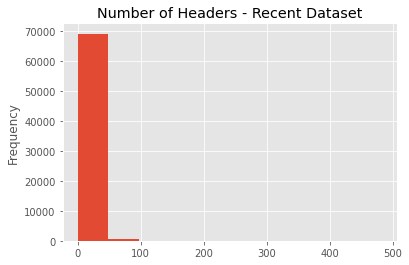

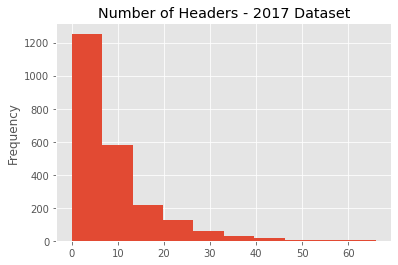

In [122]:
quant_feature = 'num_headers'
quant_feature_name = 'Number of Headers'

quant_feature_plot = md_group[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - Recent Dataset')
plt.show()

plt.clf()
quant_feature_plot = md_group_2017[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - 2017 Dataset')
plt.show()

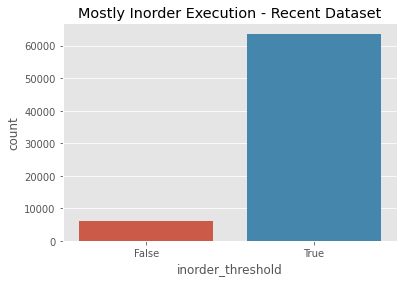

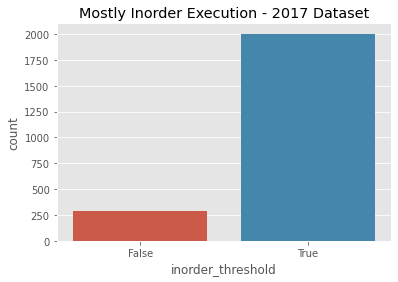

In [134]:
cat_feature = 'inorder_threshold'
cat_feature_name = 'Mostly Inorder Execution'

cat_feature_plot = sns.countplot(x = cat_feature, data = md_group)
temp = cat_feature_plot.set(title = cat_feature_name + ' - Recent Dataset')
plt.show()

plt.clf()
cat_feature_plot = sns.countplot(x = cat_feature, data = md_group_2017)
temp = cat_feature_plot.set(title = cat_feature_name + ' - 2017 Dataset')
plt.show()

### No Markdown Cell Groups

We will go through each of the best practice features and graph each for both datasets

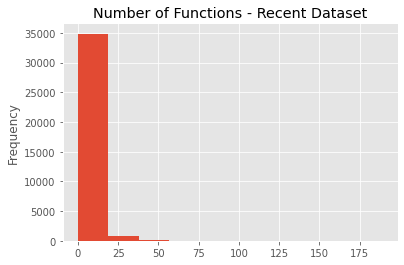

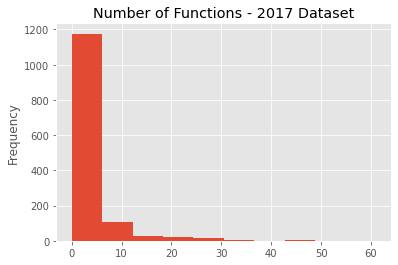

In [138]:
quant_feature = 'num_functions'
quant_feature_name = 'Number of Functions'

quant_feature_plot = no_md_group[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - Recent Dataset')
plt.show()

plt.clf()
quant_feature_plot = no_md_group_2017[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - 2017 Dataset')
plt.show()

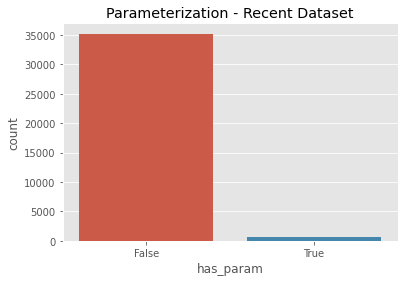

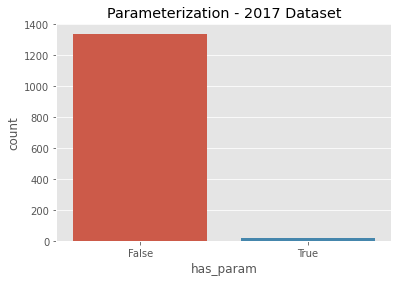

In [141]:
cat_feature = 'has_param'
cat_feature_name = 'Parameterization'

cat_feature_plot = sns.countplot(x = cat_feature, data = no_md_group)
temp = cat_feature_plot.set(title = cat_feature_name + ' - Recent Dataset')
plt.show()

plt.clf()
cat_feature_plot = sns.countplot(x = cat_feature, data = no_md_group_2017)
temp = cat_feature_plot.set(title = cat_feature_name + ' - 2017 Dataset')
plt.show()

### All Data (no group separation)

In [145]:
# combine the groups
all_data = pd.concat([md_group, no_md_group])
all_data.head()

,nb_id,repo_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,has_export,num_functions,has_test,num_headers,has_param,has_reqtext,num_stars,has_functions,has_headers,inorder_threshold
79,106,165198456,True,True,False,False,0.930911,0.363636,0.775510,1.0,...,False,2.0,False,27.0,False,False,1.0,True,True,False
80,107,165198456,True,True,False,False,0.930911,0.000000,0.775510,1.0,...,False,2.0,False,27.0,False,False,1.0,True,True,True
81,108,165197188,False,False,False,False,1.000000,0.560000,0.390244,1.0,...,False,6.0,False,13.0,False,False,1.0,True,True,True
82,109,165197188,False,False,False,False,1.000000,0.560000,0.390244,1.0,...,False,6.0,False,13.0,False,False,1.0,True,True,True
83,110,165197188,False,False,False,False,1.000000,0.588235,0.346154,1.0,...,False,8.0,False,13.0,False,False,1.0,True,True,True


In [148]:
all_data_2017 = pd.concat([md_group_2017, no_md_group_2017])
all_data_2017.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,image_prop,...,has_error,has_export,num_functions,has_test,num_headers,has_param,num_stars,has_functions,has_headers,inorder_threshold
0,594,True,False,False,False,0.507588,1.000000,0.044444,3.0,0.0,...,False,False,0.0,False,7.0,False,10.0,False,True,True
1,1222,True,False,False,False,1.000000,0.000000,0.161290,1.0,0.0,...,False,False,0.0,False,5.0,False,0.0,False,True,True
2,1447,True,False,False,False,0.970851,0.011364,0.375887,1.0,0.0,...,False,True,15.0,False,30.0,False,0.0,True,True,True
3,2705,True,False,False,False,1.000000,0.500000,0.461538,1.0,0.0,...,False,False,6.0,False,7.0,False,0.0,True,True,True
4,2861,True,False,False,True,1.000000,0.214286,0.461538,1.0,0.0,...,False,False,0.0,False,1.0,False,0.0,False,True,True


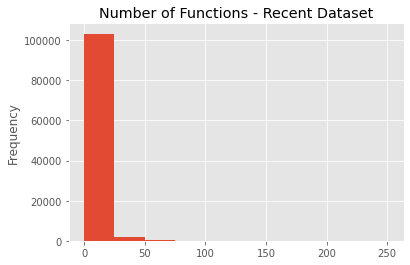

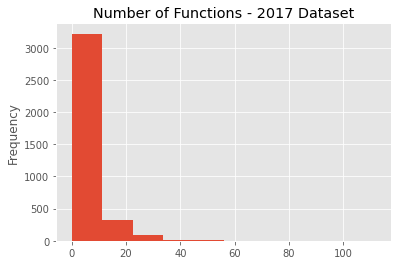

In [158]:
quant_feature = 'num_functions'
quant_feature_name = 'Number of Functions'

quant_feature_plot = all_data[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - Recent Dataset')
plt.show()

plt.clf()
quant_feature_plot = all_data_2017[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - 2017 Dataset')
plt.show()

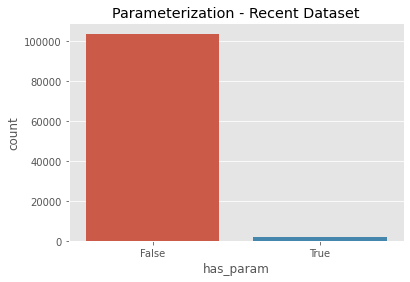

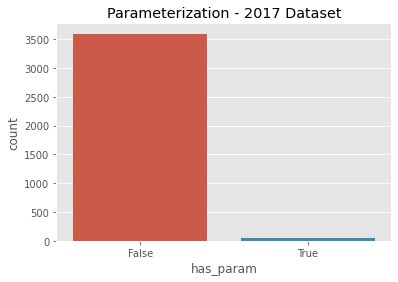

In [161]:
cat_feature = 'has_param'
cat_feature_name = 'Parameterization'

cat_feature_plot = sns.countplot(x = cat_feature, data = all_data)
temp = cat_feature_plot.set(title = cat_feature_name + ' - Recent Dataset')
plt.show()

plt.clf()
cat_feature_plot = sns.countplot(x = cat_feature, data = all_data_2017)
temp = cat_feature_plot.set(title = cat_feature_name + ' - 2017 Dataset')
plt.show()

## Graphing and Comparison (between groups, within new dataset)

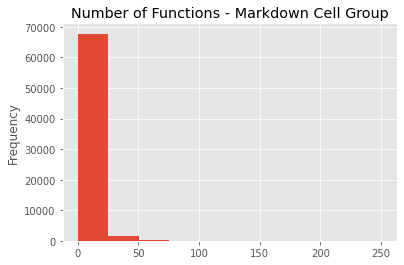

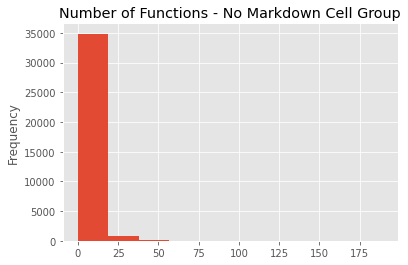

In [170]:
quant_feature = 'num_functions'
quant_feature_name = 'Number of Functions'

quant_feature_plot = md_group[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - Markdown Cell Group')
plt.show()

plt.clf()
quant_feature_plot = no_md_group[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - No Markdown Cell Group')
plt.show()

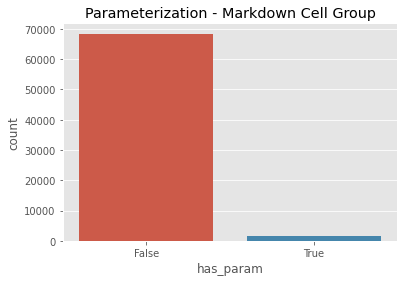

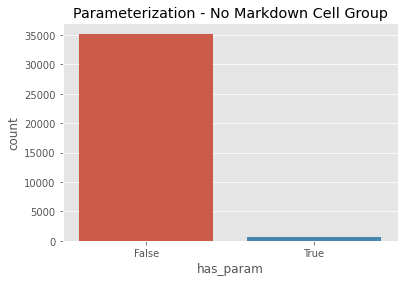

In [173]:
cat_feature = 'has_param'
cat_feature_name = 'Parameterization'

cat_feature_plot = sns.countplot(x = cat_feature, data = md_group)
temp = cat_feature_plot.set(title = cat_feature_name + ' - Markdown Cell Group')
plt.show()

plt.clf()
cat_feature_plot = sns.countplot(x = cat_feature, data = no_md_group)
temp = cat_feature_plot.set(title = cat_feature_name + ' - No Markdown Cell Group')
plt.show()

## Graphing (individual features)

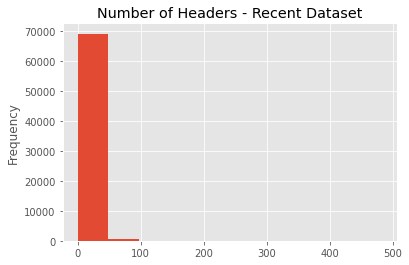

In [39]:
quant_feature = 'num_headers'
quant_feature_name = 'Number of Headers'
df = md_group.copy()

quant_feature_plot = df[quant_feature].plot(kind = 'hist')
quant_feature_plot.set_title(quant_feature_name + ' - Recent Dataset')
plt.show()

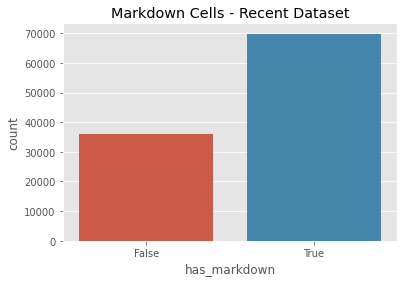

In [47]:
cat_feature = 'has_markdown'
cat_feature_name = 'Markdown Cells'
df = full_data_df.copy()

cat_feature_plot = sns.countplot(x = cat_feature, data = df)
temp = cat_feature_plot.set(title = cat_feature_name + ' - Recent Dataset')
plt.show()

In [46]:
full_data_df['has_markdown'] = full_data_df['markdown_prop'].apply(lambda x : x > 0)